In [2]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np

from scipy import stats
from dython.nominal import associations

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot  as plt
import math


In [3]:
isLastUpdate=False
label='severity_id'
labelName='severity_name'

threshold_x_sd = 2.5

removeCols=['id','updated_at','imported_at']

dateCols=['open_datetime','close_datetime','response_datetime','resolved_datetime']

numbericCols=['count_detail','open_to_close_hour','open_to_response_hour','response_to_resolved_hour']
#numbericCols=['count_detail','open_to_close_hour']

cateCols=['sla','product_type','brand','service_type','incident_type']

In [4]:
def load_data_bq(sql:str):
 client_bq = bigquery.Client()
 query_result=client_bq.query(sql)
 df_all=query_result.to_dataframe()
 return df_all

In [5]:
sql_all="""

SELECT  id,
severity_id,severity_name,
count_detail,sla,
product_type,brand,service_type,incident_type,
open_datetime,  close_datetime, response_datetime,resolved_datetime, 
updated_at,imported_at
FROM `pongthorn.SMartDW.incident` WHERE open_datetime > '2000-01-01'

order by imported_at

"""

if isLastUpdate:
    print("Load data from Bigquery")
    df_all=load_data_bq(sql_all)
    if len(df_all)>0:
     df_all.to_csv('data/Incident.csv',index=False)
    else:
     print("No records from bigquery")   
else:
    print("Load data from Load CSV")
    df_all=pd.read_csv('data/Incident.csv',parse_dates=dateCols)
    
df_all=df_all.drop_duplicates(subset=['id'],keep='first')

df_all.info()


Load data from Load CSV
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2255 entries, 0 to 2258
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2255 non-null   int64         
 1   severity_id        2255 non-null   int64         
 2   severity_name      2255 non-null   object        
 3   count_detail       2255 non-null   int64         
 4   sla                2255 non-null   object        
 5   product_type       2255 non-null   object        
 6   brand              2255 non-null   object        
 7   service_type       2255 non-null   object        
 8   incident_type      2255 non-null   object        
 9   open_datetime      2255 non-null   datetime64[ns]
 10  close_datetime     2255 non-null   datetime64[ns]
 11  response_datetime  2255 non-null   datetime64[ns]
 12  resolved_datetime  2255 non-null   datetime64[ns]
 13  updated_at         2255 non-null   obje

# Manage Numberic Cols

In [6]:
start_end_list=[ ['open_datetime','close_datetime'],['open_datetime','response_datetime'],['response_datetime','resolved_datetime']]
listDiffDateDeltaCols=[]
listDiffHourCols=[]
for item  in  start_end_list:
   diff_str=f"{item[0]}_to_{item[1]}" 
   diff_str=diff_str.replace('_datetime','')  
   listDiffDateDeltaCols.append(diff_str)
   df_all[diff_str]=df_all[item[1]]-df_all[item[0]]
    
   diff_hour=f'{diff_str}_hour'
   listDiffHourCols.append(diff_hour)
   df_all[diff_hour] = df_all[diff_str].apply(lambda x:  x.total_seconds() / (60*60) if x is not np.nan else np.nan  )
xScoreDiffHourCols=[]
for col in listDiffHourCols:
  z_col=f"zscore_{col}"   
  df_all[z_col] = np.abs(stats.zscore(df_all[col]))   
  xScoreDiffHourCols.append(z_col)  
#remove oulier

for col in  xScoreDiffHourCols:
  df_all=df_all.query(f"{col}<@threshold_x_sd")

In [7]:
print(df_all.shape)
df_all.tail()

(2201, 24)


,id,severity_id,severity_name,count_detail,sla,product_type,brand,service_type,incident_type,open_datetime,...,imported_at,open_to_close,open_to_close_hour,open_to_response,open_to_response_hour,response_to_resolved,response_to_resolved_hour,zscore_open_to_close_hour,zscore_open_to_response_hour,zscore_response_to_resolved_hour
2254,2406,2,Major,3,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,General Incident,2023-03-07 03:06:00,...,2023-03-08 21:00:05.979149,0 days 20:38:00,20.633333,0 days 00:04:00,0.066667,0 days 20:34:00,20.566667,0.214743,0.099470,0.170992
2255,2408,3,Minor,2,24x7 4Hrs Response Time,Storage,EMC,Incident,General Incident,2023-03-01 18:02:00,...,2023-03-08 21:00:05.979149,5 days 22:25:00,142.416667,0 days 16:20:00,16.333333,5 days 05:38:00,125.633333,0.042302,0.300584,0.007646
2256,2232,2,Major,17,24x7 4Hrs Response Time,Firewall,Palo Alto,Incident,Software,2023-01-30 14:40:00,...,2023-03-09 21:00:06.250701,37 days 01:41:00,889.683333,0 days 00:25:00,0.416667,37 days 00:58:00,888.966667,1.015804,0.090862,1.179095
2257,2401,2,Major,2,24x7 4Hrs Response Time,Server,HPE,Incident,General Incident,2023-03-01 23:30:00,...,2023-03-09 21:00:06.250701,0 days 03:30:00,3.500000,0 days 00:15:00,0.250000,0 days 03:15:00,3.250000,0.239003,0.094961,0.197914
2258,2084,2,Major,24,24x7 4Hrs Resolution Time,Server,HPE,Incident,General Incident,2023-01-06 11:28:00,...,2023-03-09 21:00:06.250701,61 days 21:39:00,1485.650000,0 days 00:00:00,0.000000,61 days 21:39:00,1485.650000,1.859673,0.101109,2.106749


# Find any rows  contain 0

In [8]:

# if>5%  remove column, else judge to remove 0 value 
# remove coundetail because mostly, there are few value 1,2 items
allRows=df_all.shape[0]
for col in numbericCols:
    zeroRows=len(df_all.query(f"{col}==0"))
    pctZeroHour=round(zeroRows/allRows*100,1)
    print(f"No. 0-hour row on {col} = {zeroRows}({pctZeroHour} %)")

No. 0-hour row on count_detail = 116(5.3 %)
No. 0-hour row on open_to_close_hour = 1(0.0 %)
No. 0-hour row on open_to_response_hour = 431(19.6 %)
No. 0-hour row on response_to_resolved_hour = 92(4.2 %)


# Bining Range

In [9]:
def explore_ranges_numberic_val(col,rangeList):
    print(col)
    rangeList.sort()
    return pd.cut(df_all[col],rangeList, right=True).value_counts()
range1= [0,24, 168, 360, 720,math.floor(df_all['open_to_close_hour'].max())]
print(explore_ranges_numberic_val('open_to_close_hour',range1))
print("=======================================================")

range2= [0,24, 168, 360, 720,math.floor(df_all['response_to_resolved_hour'].max())]
print(explore_ranges_numberic_val('response_to_resolved_hour',range2))
print("=======================================================")

range3= [0,4, 8, 12, 24,math.floor(df_all['open_to_response_hour'].max())]
print(explore_ranges_numberic_val('open_to_response_hour',range3))
print("=======================================================")

range4= [0,2, 4,math.floor(df_all['count_detail'].max())]
print(explore_ranges_numberic_val('count_detail',range4))
print("=======================================================")

open_to_close_hour
(0, 24]        1501
(24, 168]       441
(168, 360]      115
(720, 1845]      82
(360, 720]       60
Name: open_to_close_hour, dtype: int64
response_to_resolved_hour
(0, 24]        1565
(24, 168]       356
(168, 360]       90
(720, 1721]      54
(360, 720]       43
Name: response_to_resolved_hour, dtype: int64
open_to_response_hour
(0, 4]      1640
(12, 24]      44
(4, 8]        32
(24, 96]      31
(8, 12]       22
Name: open_to_response_hour, dtype: int64
count_detail
(0, 2]     1663
(2, 4]      254
(4, 35]     168
Name: count_detail, dtype: int64


In [10]:
print("remove some cate featurs that have imcompelte data")
numColsRemove=['open_to_response_hour','count_detail'] 
numbericCols=[x for x in numbericCols if x not in numColsRemove]   
numbericCols

remove some cate featurs that have imcompelte data


['open_to_close_hour', 'response_to_resolved_hour']

In [11]:
# remove response_to_resolved_hour ,it doesn't make any sense
df_all=df_all.query('response_to_resolved_hour!=0')

In [12]:
removeCols=removeCols+dateCols+xScoreDiffHourCols+listDiffDateDeltaCols+numColsRemove
df_all=df_all.drop(columns=removeCols)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109 entries, 1 to 2258
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2109 non-null   int64  
 1   severity_name              2109 non-null   object 
 2   sla                        2109 non-null   object 
 3   product_type               2109 non-null   object 
 4   brand                      2109 non-null   object 
 5   service_type               2109 non-null   object 
 6   incident_type              2109 non-null   object 
 7   open_to_close_hour         2109 non-null   float64
 8   response_to_resolved_hour  2109 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 164.8+ KB


In [13]:
df_all[numbericCols].describe()

,open_to_close_hour,response_to_resolved_hour
count,2109.000000,2109.000000
mean,92.811957,67.910131
std,251.322093,206.637935
min,0.166667,0.016667
25%,4.200000,3.000000
50%,8.700000,6.983333
75%,39.366667,25.033333
max,1722.083333,1721.600000


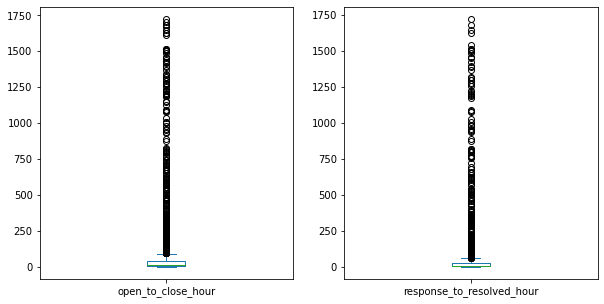

In [14]:
df_all[numbericCols].plot(kind='box',subplots=True,layout=(1,len(numbericCols)),sharex=False, sharey=False,figsize=(10,5))
plt.show()

array([[<Axes: xlabel='open_to_close_hour', ylabel='open_to_close_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='open_to_close_hour'>],
       [<Axes: xlabel='open_to_close_hour', ylabel='response_to_resolved_hour'>,
        <Axes: xlabel='response_to_resolved_hour', ylabel='response_to_resolved_hour'>]],
      dtype=object)

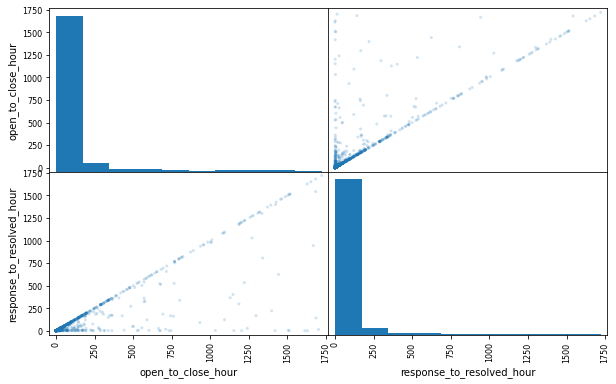

In [15]:
pd.plotting.scatter_matrix(df_all[numbericCols], alpha=0.2,figsize=(10,6))

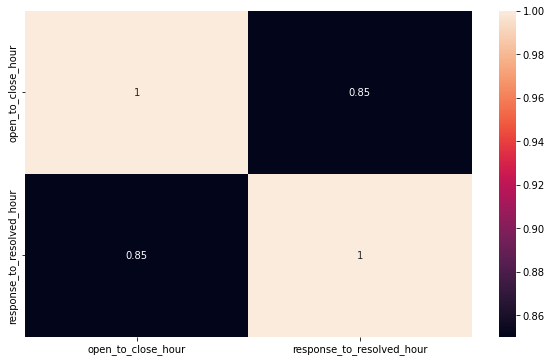

In [16]:
corr_df = df_all[numbericCols].corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (10, 6))
heatmap = sns. heatmap(corr_df, annot = True) 
plt. show ()

# Manage Categorical Cols

In [17]:
VBar=['severity_name','brand','incident_type']
HBar=[ x for x in cateCols if x not in VBar]

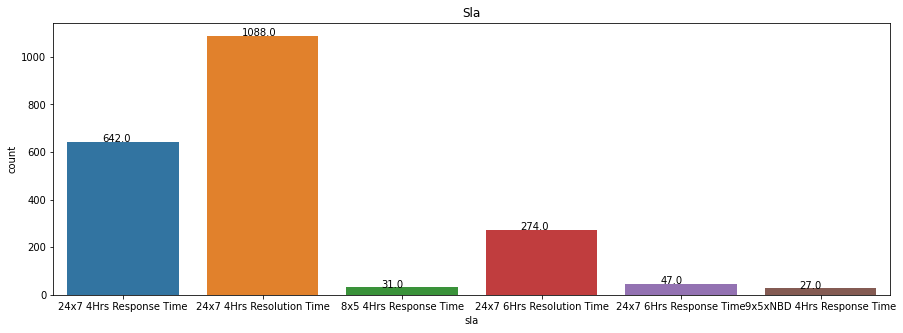

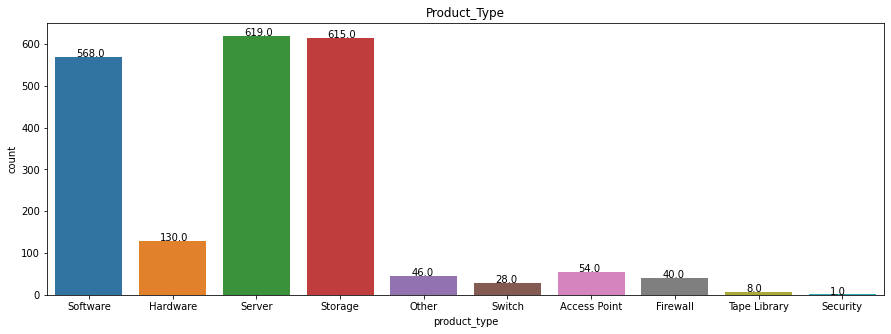

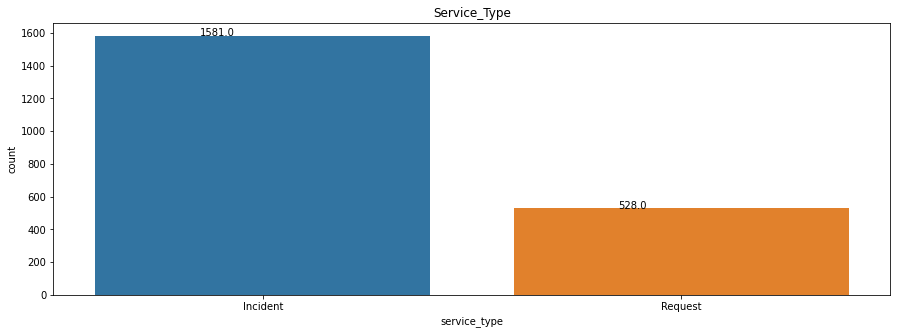

In [18]:

for col in HBar:
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=col, data=df_all,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(col.title())
    plt.show()

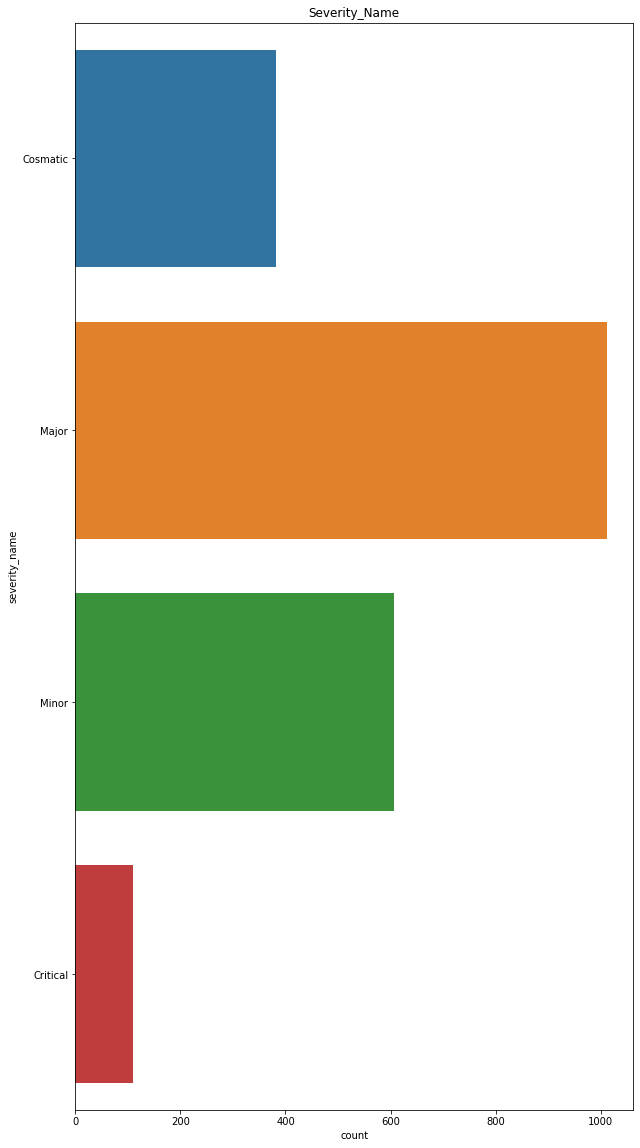

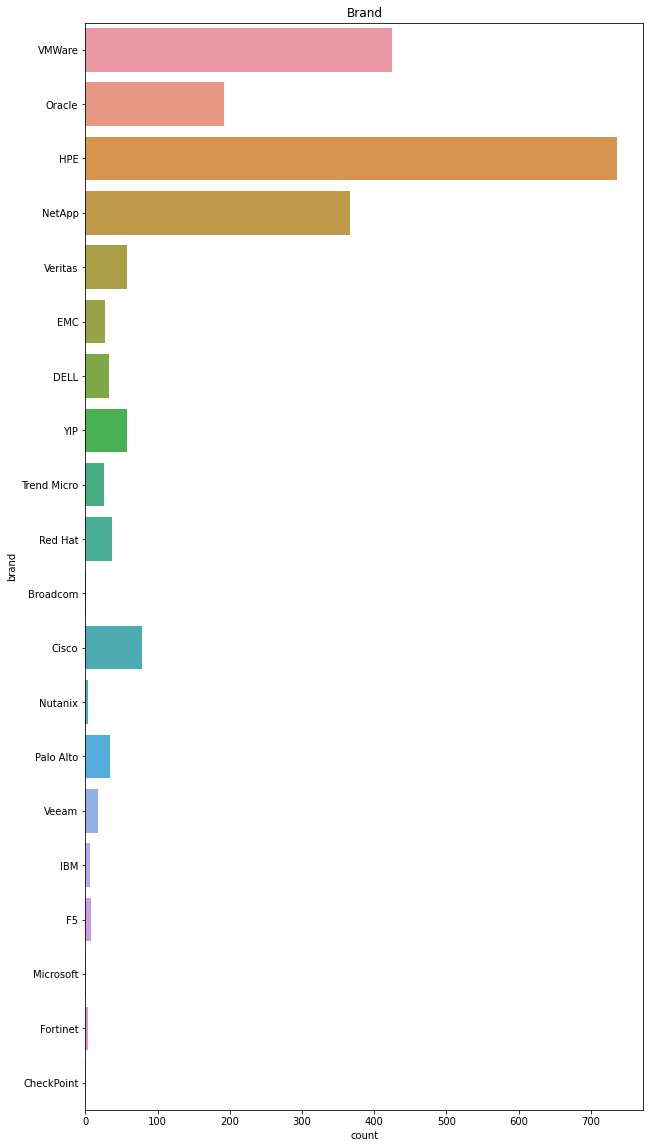

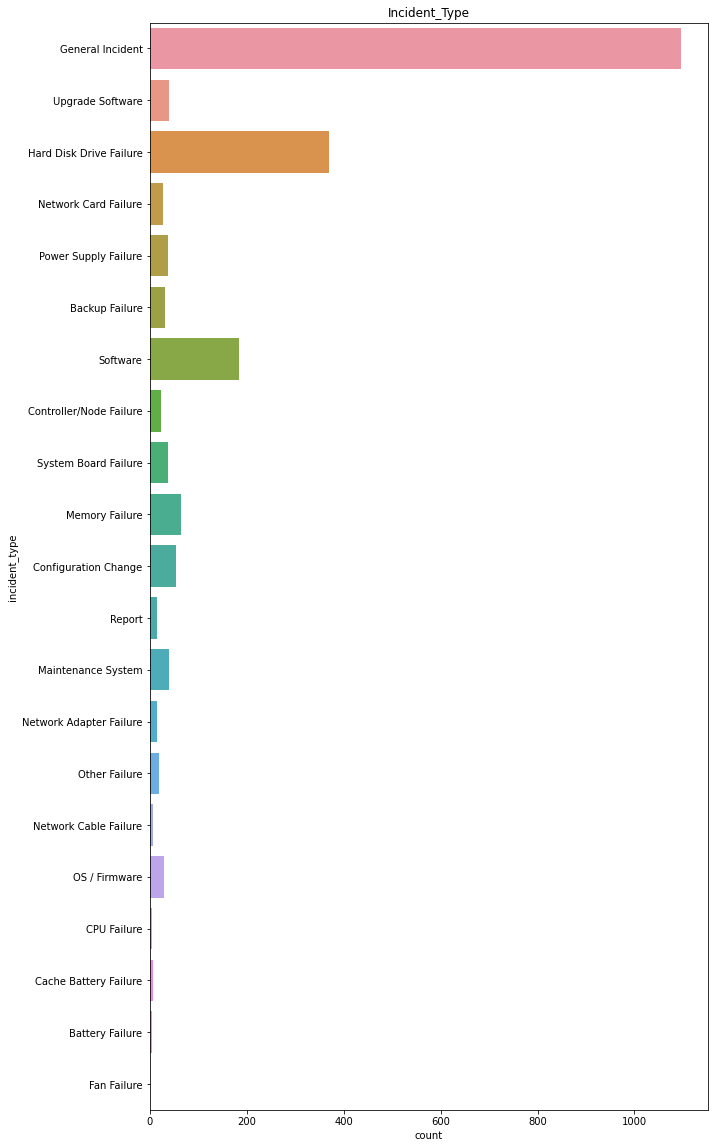

In [19]:
for col in VBar:
    fig , ax = plt.subplots(figsize=(10,20))
    ax =sns.countplot(y=col, data=df_all)
    plt.title(col.title())
    plt.show()

In [19]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2109 entries, 1 to 2258
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   severity_id                2109 non-null   int64  
 1   severity_name              2109 non-null   object 
 2   sla                        2109 non-null   object 
 3   product_type               2109 non-null   object 
 4   brand                      2109 non-null   object 
 5   service_type               2109 non-null   object 
 6   incident_type              2109 non-null   object 
 7   open_to_close_hour         2109 non-null   float64
 8   response_to_resolved_hour  2109 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 164.8+ KB


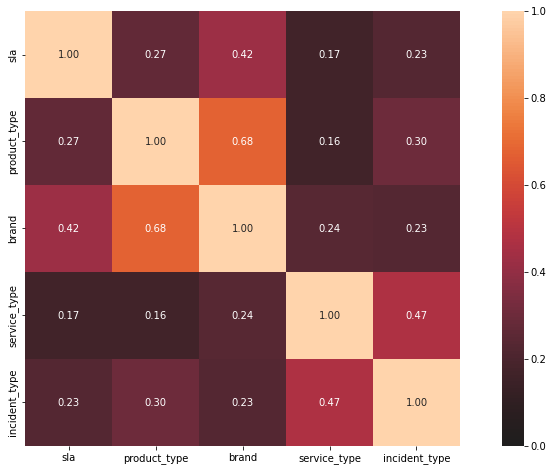

In [36]:
complete_correlation= associations(df_all[ [x for x in list(df_all.columns) if x not in ['severity_id','severity_name']+numbericCols]  ], figsize=(15,8))

In [37]:
df_all.to_csv("data/TrainEval_Incident.csv",index=False)